# Data Set

In [55]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as tt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np


In [56]:
IMAGE_SIZE = 256
BATCH_SIZE = 1


class VisualWSDDataset(Dataset):
    def __init__(self, mode="train", image_transform=None, text_transform=None, tokenizer=None, test_lang='en'):
        self.image_transform = image_transform
        self.text_transform = text_transform
        self.tokenizer = tokenizer
        self.mode = mode

        self.base_path = './data/semeval-2023-task-1-V-WSD-train-v1/train_v1/'
        self.data_txt_path = self.base_path + 'train.data.v1.txt'
        self.gold_txt_path = self.base_path + 'train.gold.v1.txt'
        self.image_path = self.base_path + '/train_images_v1/'

        if mode == "test":
            self.base_path = './data/'
            self.data_txt_path = self.base_path + test_lang + '.test.data.v1.1.txt'
            self.gold_txt_path = self.base_path + test_lang + '.test.gold.v1.1.txt'
            self.image_path = self.base_path + '/test_images_resized/'

            if test_lang == 'fa':
                self.data_txt_path = self.base_path + test_lang + '.test.data.txt'
                self.gold_txt_path = self.base_path + test_lang + '.test.gold.txt'
        elif mode == "val":
            self.base_path = './data/semeval-2023-task-1-V-WSD-train-v1/trial_v1/'
            self.data_txt_path = self.base_path + 'trial.data.v1.txt'
            self.gold_txt_path = self.base_path + 'trial.gold.v1.txt'
            self.image_path = self.base_path + '/trial_images_v1/'
        

        # load txts
        self.data_df = pd.read_csv(self.data_txt_path, delimiter = "\t", header=None)
        self.gold_df = pd.read_csv(self.gold_txt_path, delimiter = "\t", header=None)
        self.data_gold_df  = pd.concat([self.data_df.iloc[:, 0], self.data_df.iloc[:, 1], self.gold_df.iloc[:, 0]], axis=1, keys=['label', 'label_context', 'img_name'])
        if self.tokenizer != None:
            self.gold_token = self.tokenizer(self.data_gold_df['label_context'].to_list())

    def __len__(self):
        return len(self.data_gold_df)

    def __getitem__(self, idx):
        label = self.data_gold_df.iloc[idx]['label']
        label_context = self.data_gold_df.iloc[idx]['label_context']
        correct_image_name = self.data_gold_df.iloc[idx]['img_name']
        images_series = self.data_df.iloc[idx][2:]
        correct_image_idx = images_series[images_series == correct_image_name].index[0]-2
        images = []

        if self.mode == "test":
            for item in images_series:
                    images.append(Image.open(self.image_path + item).convert('RGB'))
            correct_image = images[correct_image_idx]
        else:
            correct_image = Image.open(self.image_path + images_series[correct_image_idx+2]).convert('RGB')

        if self.image_transform:
            correct_image = self.image_transform(correct_image)
            for idx in range(len(images)):
                images[idx] = self.image_transform(images[idx])

        if self.text_transform:
            label = self.text_transform(label)
            label_context = self.text_transform(label_context)

        if self.tokenizer != None:
            # labels are the correct images
            # input_ids and attention_mask are tokenized text
            item = {key: torch.tensor(val[idx]) for key, val in self.gold_token.items()}
            item['images'] = torch.tensor(correct_image)
            return item

        return {'label': label, 'label_context': label_context, 'correct_idx': correct_image_idx, 'correct_img': correct_image, 'imgs': images}

In [57]:
scale = tt.Resize((IMAGE_SIZE, IMAGE_SIZE))
tensor = tt.ToTensor()
image_composed = tt.transforms.Compose([scale, tensor])

In [58]:
train_set = VisualWSDDataset(mode="train", image_transform=image_composed)
test_set = VisualWSDDataset(mode="test", image_transform=image_composed, test_lang='en')
trial_set = VisualWSDDataset(mode="val", image_transform=image_composed)

In [68]:
print(len(train_set))
print(len(test_set))
print(len(trial_set))


12869
463
16


In [59]:
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [60]:
def visualize_set(data_set):
    for i, sample in enumerate(data_set):
        print(i, sample['label'], sample['label_context'], len(sample['imgs']), sample['correct_idx'])
        
        if len(sample['imgs']) > 0:
            imshow(torchvision.utils.make_grid(sample['imgs']))
        imshow(sample['correct_img'])
        
        if i == 3:
            break

0 moorhen moorhen swamphen 0 5


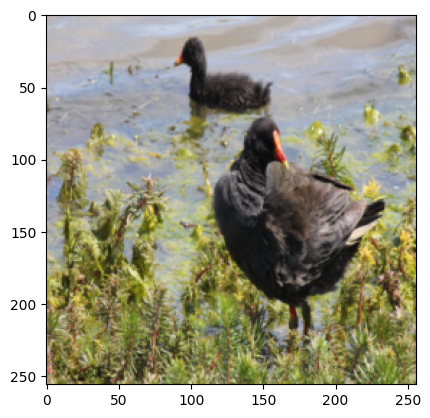

1 serinus serinus genus 0 5


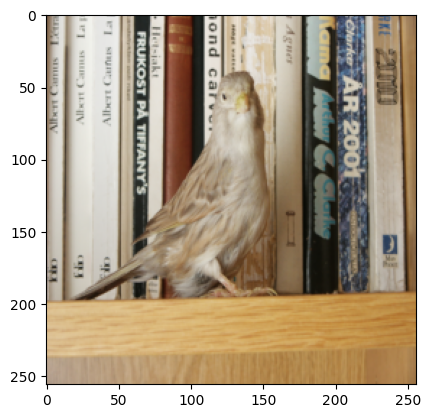

2 pegmatite pegmatite gneous 0 9


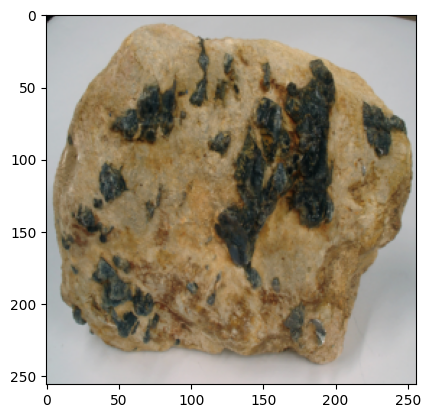

3 bangalores bangalores torpedo 0 4


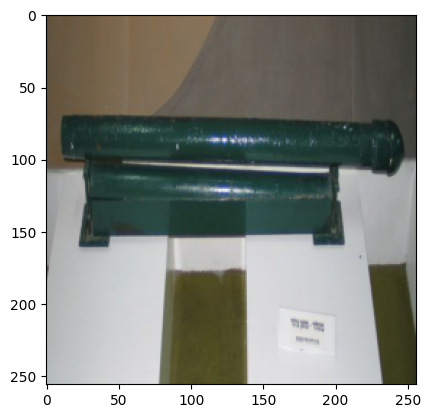

In [61]:
visualize_set(train_set)

0 goal football goal 10 8


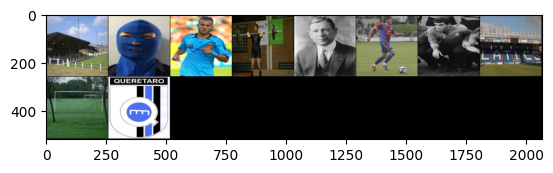

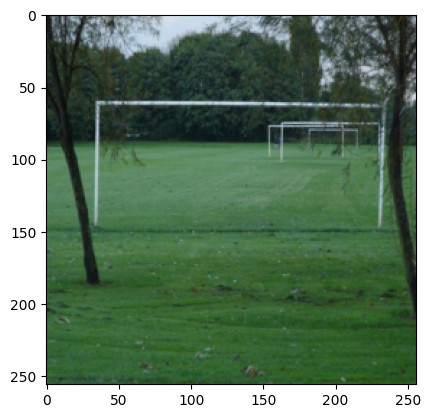

1 mustard mustard seed 10 0


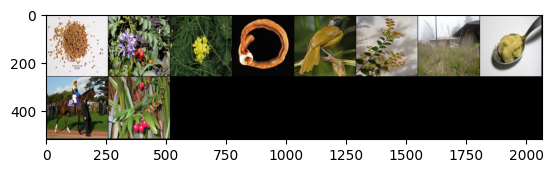

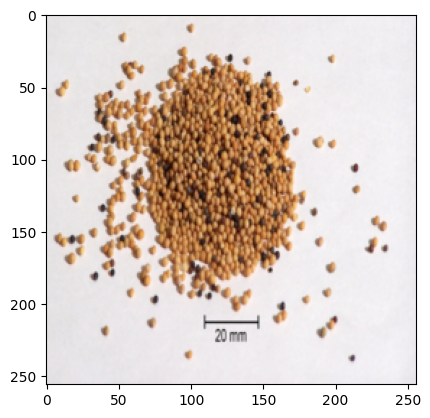

2 seat eating seat 10 5


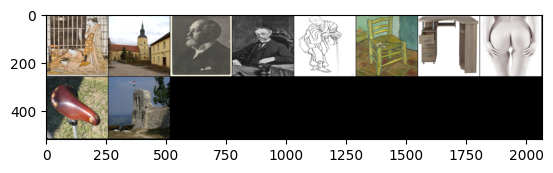

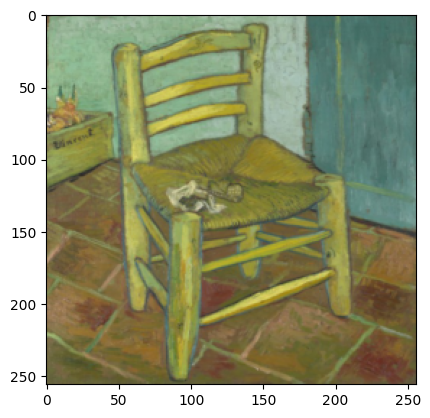

3 navigate navigate the web 10 6


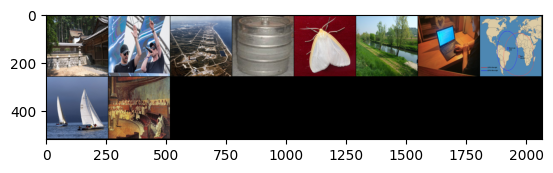

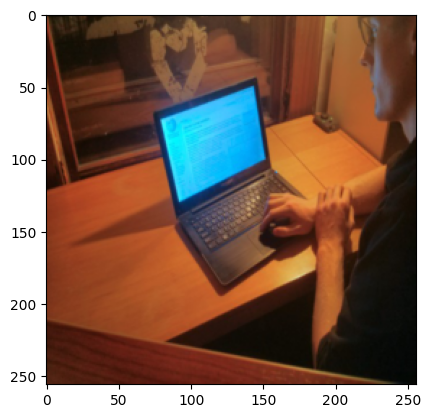

In [62]:
visualize_set(test_set)

0 andromeda andromeda tree 0 5


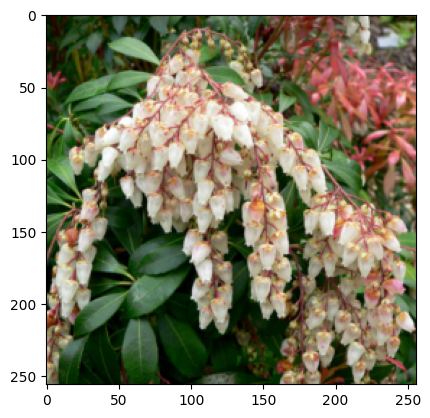

1 angora angora city 0 3


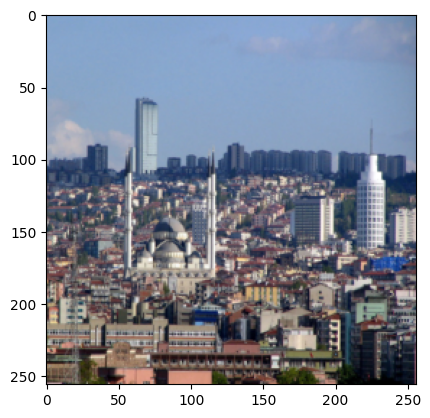

2 anteater marsupial anteater 0 2


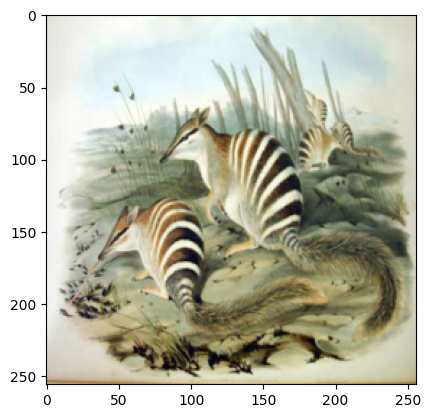

3 bank bank erosion 0 1


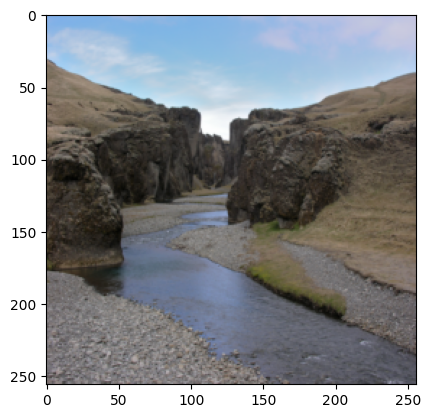

In [63]:
visualize_set(trial_set)

In [64]:
from transformers import DistilBertTokenizerFast

def tokens(texts):
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    return tokenizer(texts, truncation=True, padding=True)

In [70]:
trial_set_token = VisualWSDDataset(mode="val", image_transform=image_composed, tokenizer=tokens)
train_set_token = VisualWSDDataset(mode="train", image_transform=image_composed, tokenizer=tokens)

In [71]:
print(len(trial_set_token))
print(len(train_set_token))

16
12869


In [66]:
trial_set_token[0]

/tmp/ipykernel_137420/2594091424.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['images'] = torch.tensor(correct_image)


{'input_ids': tensor([  101,  1998, 21716, 11960,  3392,   102,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0]),
 'images': tensor([[[0.0510, 0.0118, 0.0510,  ..., 0.3098, 0.3059, 0.3216],
          [0.1098, 0.0431, 0.0549,  ..., 0.2510, 0.2471, 0.2667],
          [0.0667, 0.0510, 0.0784,  ..., 0.1490, 0.1294, 0.1804],
          ...,
          [0.6471, 0.5412, 0.4784,  ..., 0.1294, 0.1333, 0.1882],
          [0.5922, 0.4941, 0.4706,  ..., 0.1569, 0.1412, 0.2275],
          [0.5765, 0.5059, 0.4941,  ..., 0.1608, 0.1725, 0.3255]],
 
         [[0.1059, 0.0863, 0.0706,  ..., 0.3216, 0.3294, 0.3451],
          [0.1333, 0.0980, 0.0588,  ..., 0.2549, 0.2627, 0.2941],
          [0.1333, 0.0980, 0.0431,  ..., 0.1451, 0.1490, 0.2078],
          ...,
          [0.6627, 0.5529, 0.4667,  ..., 0.2706, 0.3059, 0.3020],
          [0.6078, 0.4980, 0.4706,  ..., 0.3137, 0.2863, 0.2510],
          [0.5843, 0.5059, 0.4980,  ..., 0.3137, 0.2627, 0.2235]],
 
         [[0.0235, 0.0039, 0.